# Script to Build Materials for training for Data 88E

In [ ]:
try:
    from pptx import Presentation
except ImportError:
    !pip install python-pptx
    from pptx import Presentation
import yaml
from pathlib import Path
import re


## Step 1 - Slide Decks 
Find the slide decks in the `slides` folder.
For Instance Fall 2024 Slides are in:
https://drive.google.com/drive/folders/1fJ7Hi76MdVOmvlb73nTl08ey0W1jXWdM

We need to get these into a format that can be used to train an LLM.

I went to the drive folder and clicked on download. This created a zip file with all the slides in it.



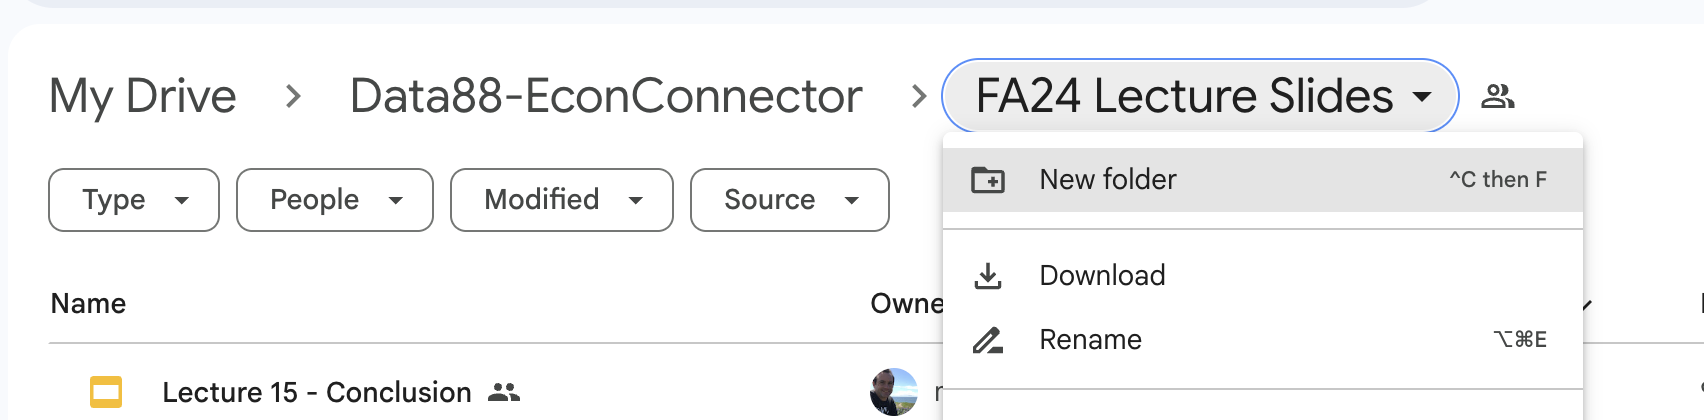

In [ ]:
#List the most recent files in Downloads

!ls -lt ~/Downloads | head
#!ls ~/Downloads/

In [ ]:
# Make a new directory for the training materials
!mkdir -p "$HOME/Documents/Data88E-ForTraining/"
# Move the zip file to the right directory
!cp "$HOME/Downloads/FA24 Lecture Slides-20250908T170748Z-1-001.zip" "$HOME/Documents/Data88E-ForTraining/"

#### Note - I have 15 weeks of slides and they have the week number in the filename. ( other files may not have this )

In [ ]:
!ls ~/Documents/Data88E-ForTraining/


In [ ]:
## unzip the file
!unzip "$HOME/Documents/Data88E-ForTraining/FA24 Lecture Slides-20250908T170748Z-1-001.zip"

In [ ]:
# I need to rename the folder
!mv "$HOME/Documents/Data88E-ForTraining/FA24 Lecture Slides" "$HOME/Documents/Data88E-ForTraining/F24LS"

In [ ]:
%cd ~/Documents/Data88E-ForTraining/F24LS 
!pwd
!ls

## Making a script to convert pptx to markdown


In [ ]:

# Script to convert pptx to markdown using python-pptx
# Saves each slide as a markdown header with bullet points for text
# Speaker notes are included in a collapsible section


def md_escape(s): 
    return (s or "").replace("*","\\*").replace("_","\\_").replace("#","\\#")

def para_to_md(p):
    txt = "".join(r.text for r in p.runs).strip()
    if not txt: return ""
    indent = "  " * (p.level or 0)
    return f"{indent}- {md_escape(txt)}"

def slide_title(slide):
    if slide.shapes.title and hasattr(slide.shapes.title, "text"):
        return slide.shapes.title.text.strip()
    for shp in slide.shapes:
        if getattr(shp, "has_text_frame", False):
            t = shp.text.strip()
            if t: return t
    return ""

def extract_notes(slide):
    try:
        ns = slide.notes_slide
        if ns and ns.notes_text_frame:
            return ns.notes_text_frame.text.strip()
    except Exception:
        pass
    return ""

def extract_body(slide):
    lines = []
    for shp in slide.shapes:
        if shp == slide.shapes.title: 
            continue
        if getattr(shp, "has_text_frame", False):
            for p in shp.text_frame.paragraphs:
                md = para_to_md(p)
                if md: lines.append(md)
    return lines

WEEK_NUM_RE = re.compile(r"\d+")

def infer_week_from_filename(p: Path, valid_min=1, valid_max=60):
    m = WEEK_NUM_RE.search(p.stem)
    if not m:
        return None
    w = int(m.group(0))
    return w if valid_min <= w <= valid_max else None

def pptx_to_md(pptx_path: Path, out_path: Path):
    prs = Presentation(pptx_path)
    week = infer_week_from_filename(pptx_path)

    with out_path.open("w", encoding="utf-8") as md:
        md.write("---\n")
        md.write(f'title: "{md_escape(pptx_path.stem)}"\n')
        md.write("type: slides\n")
        if week is not None:
            md.write(f"week: {week}\n")
        md.write(f'source_path: "{pptx_path}"\n')
        md.write("---\n\n")

        for i, slide in enumerate(prs.slides, start=1):
            title = slide_title(slide) or "(untitled)"
            md.write(f"## Slide {i}: {md_escape(title)}\n\n")

            body = extract_body(slide)
            if body:
                md.write("\n".join(body) + "\n\n")

            notes = extract_notes(slide)
            if notes:
                md.write("<details><summary>Speaker notes</summary>\n\n")
                md.write("\n".join(md_escape(x) for x in notes.splitlines()) + "\n\n</details>\n\n")

    print(f"Converted {pptx_path.name} → {out_path.name} (week={week})")


In [ ]:

# --- run it once on the test deck ---
# --- point this to one specific file you want to test ---
pptx_file = Path("~/Documents/Data88E-ForTraining/F24LS/Lecture 2 - Demand.pptx").expanduser()
out_file  = pptx_file.with_suffix(".md")


pptx_to_md(pptx_file, out_file)

In [ ]:
# Now run it on all the decks in a folder

# --- configure your folders ---
INPUT_DIR  = Path("~/Documents/Data88E-ForTraining/F24LS").expanduser()
OUTPUT_DIR = Path("~/Documents/Data88E-ForTraining/F24LS_md").expanduser()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Gather all .pptx in the folder (non-recursive). Use .rglob("*.pptx") to recurse.
pptx_files = sorted(p for p in INPUT_DIR.iterdir() if p.suffix.lower() == ".pptx")

if not pptx_files:
    print(f"No .pptx files found in {INPUT_DIR}")
else:
    print(f"Found {len(pptx_files)} decks. Converting to: {OUTPUT_DIR}\n")

    failures = []
    for idx, pptx_path in enumerate(pptx_files, start=1):
        out_md = OUTPUT_DIR / pptx_path.with_suffix(".md").name
        try:
            pptx_to_md(pptx_path, out_md)  # <-- reuses the function you already tested
        except Exception as e:
            failures.append((pptx_path.name, str(e)))
            print(f"⚠️ Failed on {pptx_path.name}: {e}")

    if failures:
        print("\nDone with errors on these files:")
        for name, err in failures:
            print(f" - {name}: {err}")
    else:
        print("\nAll decks converted successfully ✅")

## Step 4 Make a summary yaml file of the slide decks

In [ ]:
# --- Build summary.yaml from Markdown front-matter ---
try:
    import yaml
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyyaml"])
    import yaml

from pathlib import Path

MD_DIR = Path("~/Documents/Data88E-ForTraining/F24LS_md").expanduser()
summary_path = MD_DIR / "summary.yaml"

def read_front_matter(md_path: Path) -> dict:
    """Read YAML front matter (between --- markers) and return as dict."""
    lines = md_path.read_text(encoding="utf-8").splitlines(True)
    if not lines or lines[0].strip() != "---":
        return {}
    try:
        end_idx = lines.index("---\n", 1)
    except ValueError:
        return {}
    return yaml.safe_load("".join(lines[1:end_idx])) or {}

records = []
for md_file in sorted(MD_DIR.glob("*.md")):
    meta = read_front_matter(md_file)
    records.append({
        "file": md_file.name,
        "title": meta.get("title", md_file.stem),
        "type": meta.get("type", "slides"),
        "source_path": meta.get("source_path", ""),
        "week": meta.get("week")
    })

# Order strictly by week (1..15), fall back to alpha if week missing
with_week    = [r for r in records if isinstance(r["week"], int)]
without_week = [r for r in records if not isinstance(r["week"], int)]

with_week.sort(key=lambda r: r["week"])
without_week.sort(key=lambda r: r["title"].lower())

ordered = with_week + without_week
for i, r in enumerate(ordered, start=1):
    r["order"] = i

# Write summary.yaml
summary_path.write_text(
    yaml.safe_dump(ordered, sort_keys=False, allow_unicode=True),
    encoding="utf-8"
)

print(f"Wrote {summary_path} with {len(ordered)} entries.")
if without_week:
    print("Note: These files had no 'week' in front matter and were placed at the end:")
    for r in without_week:
        print(" -", r["file"])